## [Les victoires blanches aux échecs: Etude d'une database lichess]

<u>Introduction:</u>

Lichess est une plate-forme d'échecs en ligne, elle est gratuite et open-source. La plate-forme met à disposition des Databases comprenant les parties jouées sur son site chaque mois (elle propose aussi une excellente API). Ces bases sont disponibles ici: https://database.lichess.org/. Pour ce projet, j'ai utilisé la base de décembre 2017.

Dans ce projet, je vais m'intéresser aux victoires blanches aux échecs. En effet, dans le jeu d'échec, les blancs jouent en premier et cela leur procure un avantage. L'étude d'une database lichess va me permettre de mesurer cet avantage dans la pratique et quels facteurs l'accentuent, le diminuent voire l'inversent! Je vais notamment m'attarder sur le elo (classement) des joueurs et sur l'ouverture (type de début de parties). 

Dans l'intégralité de ce projet, je vais utiliser différents modules que je vous demande de bien vouloir importer dès à présent en exécutant la cellule de code suivante:

In [2]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import s3fs
import zstandard as zstd
import codecs


<u>Récupération des données et création de la Database:</u>

La base de données de que je vais utiliser est celle de décembre 2017 récupérable ici: https://database.lichess.org/ . Cependant, elle est au format .zst et est très volumineuse même compressée. Elle n'est donc pas stockée dans mon deposit git mais sur mon SSP cloud. Vous pouvez y accéder via la cellule de code suivante:

In [2]:
MY_BUCKET = "charlret"
##Je sais que les clefs d'accès à notre service ne sont pas censées être présente dans notre code et qu'elles sont rafraichis à intervalle régulier 
##mais ce code fourni par la plate-forme onyxia et le seul moyen que j'ai trouvé afin d'éviter les erreurs d'accès à mes fichiers

os.environ["AWS_ACCESS_KEY_ID"] = 'FVWK0NHMH7H731QHWURF'
os.environ["AWS_SECRET_ACCESS_KEY"] = 'RJ5oGkNswBPVxH76iVt2dwizr5+A7HiKEANj0lC7'
os.environ["AWS_SESSION_TOKEN"] = 'eyJhbGciOiJIUzUxMiIsInR5cCI6IkpXVCJ9.eyJhY2Nlc3NLZXkiOiJGVldLME5ITUg3SDczMVFIV1VSRiIsImFsbG93ZWQtb3JpZ2lucyI6WyIqIl0sImF1ZCI6WyJtaW5pby1kYXRhbm9kZSIsIm9ueXhpYSIsImFjY291bnQiXSwiYXV0aF90aW1lIjoxNzM0NTEyMjk5LCJhenAiOiJvbnl4aWEiLCJlbWFpbCI6ImNoYXJsZXMuZGVyYWluQGVuc2FlLmZyIiwiZW1haWxfdmVyaWZpZWQiOnRydWUsImV4cCI6MTczNTkwNDk5MCwiZmFtaWx5X25hbWUiOiJEZXJhaW4iLCJnaXZlbl9uYW1lIjoiQ2hhcmxlcyIsImdyb3VwcyI6WyJVU0VSX09OWVhJQSJdLCJpYXQiOjE3MzUzMDAxODgsImlzcyI6Imh0dHBzOi8vYXV0aC5sYWIuc3NwY2xvdWQuZnIvYXV0aC9yZWFsbXMvc3NwY2xvdWQiLCJqdGkiOiIyYTgxNWU1Ny0zZDEyLTRjOGQtOGM2My04Njk3NWU1Nzc3YjIiLCJuYW1lIjoiQ2hhcmxlcyBEZXJhaW4iLCJwb2xpY3kiOiJzdHNvbmx5IiwicHJlZmVycmVkX3VzZXJuYW1lIjoiY2hhcmxyZXQiLCJyZWFsbV9hY2Nlc3MiOnsicm9sZXMiOlsib2ZmbGluZV9hY2Nlc3MiLCJ1bWFfYXV0aG9yaXphdGlvbiIsImRlZmF1bHQtcm9sZXMtc3NwY2xvdWQiXX0sInJlc291cmNlX2FjY2VzcyI6eyJhY2NvdW50Ijp7InJvbGVzIjpbIm1hbmFnZS1hY2NvdW50IiwibWFuYWdlLWFjY291bnQtbGlua3MiLCJ2aWV3LXByb2ZpbGUiXX19LCJyb2xlcyI6WyJvZmZsaW5lX2FjY2VzcyIsInVtYV9hdXRob3JpemF0aW9uIiwiZGVmYXVsdC1yb2xlcy1zc3BjbG91ZCJdLCJzY29wZSI6Im9wZW5pZCBwcm9maWxlIGdyb3VwcyBlbWFpbCIsInNpZCI6ImRmYzMwNjZkLWFjZjEtNDFmZi04ODU2LWUzNjlkMzFiZjk5OCIsInN1YiI6Ijg3MGIwZWRjLTE2ZGQtNDRmOS1hMDRjLWMyNzNiMzcyOGYyNiIsInR5cCI6IkJlYXJlciJ9.fZwXn4U5ak5NCLCz1wZcPNAqwsYcw7GqGavNIVEMUvtEGeg2uIkoO4Zv7COnNtkWsprn0KtGgj9EU7tMoSbqGA'
os.environ["AWS_DEFAULT_REGION"] = 'us-east-1'

fs = s3fs.S3FileSystem(
    client_kwargs={'endpoint_url': 'https://'+'minio.lab.sspcloud.fr'},
    key = os.environ["AWS_ACCESS_KEY_ID"], 
    secret = os.environ["AWS_SECRET_ACCESS_KEY"], 
    token = os.environ["AWS_SESSION_TOKEN"])

file_key = "diffusion/Data2017.zst"  
output_file = "Data_compressed.zst" 

with fs.open(f"{MY_BUCKET}/{file_key}", mode='rb') as s3_file:
    with open(output_file, 'wb') as local_file:
        local_file.write(s3_file.read())



Il faut maintenant décompresser cette base qui est déjà très volumineuse. J'ai choisi de la décompresser et de noter les informations décompressées dans un fichier .txt intermédiaire car la mémoire finie par être saturée. Vous pouvez obtenir ce fichier .txt en exécutant la cellule suivante:

In [5]:
input_file = "Data_compressed.zst"   
output_file = "Data.txt"  

with open(input_file, 'rb') as compressed_file:  
    decompressor = zstd.ZstdDecompressor()
    with decompressor.stream_reader(compressed_file) as reader:  
        decoder = codecs.getincrementaldecoder('utf-8')()  
        with open(output_file, 'w', encoding='utf-8') as local_file:
            while True:
                chunk = reader.read(16384)  
                if not chunk:
                    break
                decoded_chunk = decoder.decode(chunk)  
                local_file.write(decoded_chunk)  

decoded_remainder = decoder.decode(b'', final=True)
if decoded_remainder:
    with open(output_file, 'a', encoding='utf-8') as local_file:
        local_file.write(decoded_remainder)

OSError: [Errno 28] No space left on device

Cette cellule va normalement retourner une erreur du au manque d'espace de stockage. Son exécution permet tout de même d'obtenir un fichier .txt contenant un nombre très important de PGN (format de notations des parties d'échecs). Il faut maintenant transformer ce fichier .txt en un dataframe que l'on pourra manipuler avec pandas. Avant d'exécuter ce code, je vous invite à supprimer le fichier Data2017.zst qui alourdit le service VScode. La cellule suivante permet ensuite de créer le dataframe voulu et l'enregistre au format csv.

In [7]:
def parse_and_filter_txt(txt_path, required_fields=None, max_games=500000):
    
    if required_fields is None:
        required_fields = ['WhiteElo', 'BlackElo', 'Opening', 'TimeControl', 'Termination']
    game_data = [] 
    with open(txt_path, 'r', encoding='utf-8') as f:
        txt_content = f.read()
    games = txt_content.strip().split("\n\n")
    for game in games:
        lines = game.split("\n")
        metadata_lines = [line for line in lines if line.startswith("[")]
        moves_lines = [line for line in lines if not line.startswith("[")]
        metadata = dict(re.findall(r'\[(\w+) "(.*?)"\]', "\n".join(metadata_lines)))
        if all(field in metadata for field in required_fields):
            moves = " ".join(moves_lines).replace('\n', ' ')  # Joindre les coups en une seule chaîne
            metadata['Moves'] = moves
            game_data.append(metadata)
        if len(game_data) >= max_games:
            break
    df = pd.DataFrame(game_data)
    return df


txt_file = "/home/onyxia/work/data/Data.txt"
required_fields = ['WhiteElo', 'BlackElo', 'Opening', 'TimeControl', 'Termination']
df = parse_and_filter_txt(txt_file, required_fields=required_fields, max_games=500000)




output_csv = "Data_uncleaned.csv"
df.to_csv(output_csv, index=False, encoding='utf-8-sig')
print(df.shape)

(500000, 18)


Ce code permet de créer un dataframe à partir de notre fichier txt. Je me suis limité à 500 000 parties pour des raisons de taille de fichier. Il sélectionne aussi uniquement les parties contenant les entrées qui nous intéressent (classement des 2 joueurs, résultat de la partie, ouverture, cadence et type de fin de partie). Ce dataframe comprend cependant d'autres entrées. Plus de détails en exécutant le code suivant:

In [8]:
print(df.columns)

Index(['Event', 'Site', 'White', 'Black', 'Result', 'UTCDate', 'UTCTime',
       'WhiteElo', 'BlackElo', 'WhiteRatingDiff', 'BlackRatingDiff', 'ECO',
       'Opening', 'TimeControl', 'Termination', 'Moves', 'WhiteTitle',
       'BlackTitle'],
      dtype='object')


On va maintenant supprimer les colonnes inutiles de notre dataframe via le code suivant:

In [10]:
columns_to_keep = ['Result', 'WhiteElo', 'BlackElo', 'ECO', 'Opening', 'Termination', 'Moves', 'TimeControl']
df_filtered = df[columns_to_keep]
output_csv = "Database_finale.csv"
df_filtered.to_csv(output_csv, index=False, encoding='utf-8-sig')
print(df_filtered.columns)

Index(['Result', 'WhiteElo', 'BlackElo', 'ECO', 'Opening', 'Termination',
       'Moves', 'TimeControl'],
      dtype='object')


Une fois cette cellule exécutée avec succès, vous devriez avoir obtenue le fichier .csv Database_finale qui représente la base que je vais utiliser dans la suite de mon projet. Vous pouvez d'ailleurs supprimer les fichiers intermédiaires tels que Data.txt.

<u>Les statistiques vérifient-elles notre hypothèse?</u>

On peut désormais entrer dans le vif du sujet et tracer des diagrammes illustrant les victoires de chaque couleur ainsi que les parties nulles.
On commence par un diagramme simple présentant les parts de chaque résultat dans l'intégralité de la base via le code suivant:

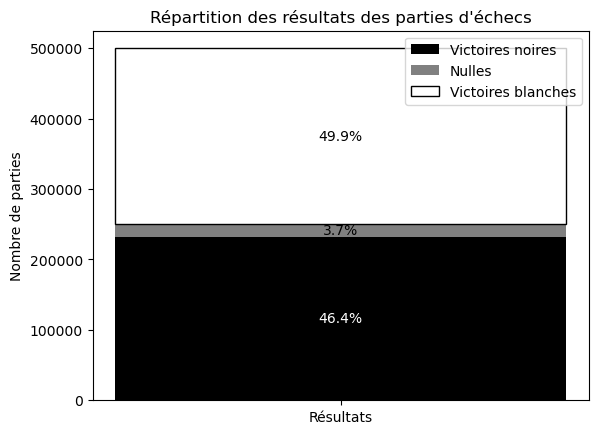

In [11]:
csv_file_path = "/home/onyxia/work/data/Database_finale.csv"
df = pd.read_csv(csv_file_path)
valid_results = {"1-0", "0-1", "1/2-1/2"}
result_column = "Result"
df_valid = df[df[result_column].isin(valid_results)]
results_count = df_valid[result_column].value_counts()

black_wins = results_count.get("0-1", 0)
draws = results_count.get("1/2-1/2", 0)
white_wins = results_count.get("1-0", 0)
total_games = black_wins + draws + white_wins
black_wins_percent = (black_wins / total_games) * 100
draws_percent = (draws / total_games) * 100
white_wins_percent = (white_wins / total_games) * 100

labels = ["Résultats"]
bar_black = [black_wins]
bar_draws = [draws]
bar_white = [white_wins]

plt.bar(labels, bar_black, color="black", label="Victoires noires")
plt.bar(labels, bar_draws, bottom=bar_black, color="gray", label="Nulles")
plt.bar(labels, bar_white, bottom=[b + d for b, d in zip(bar_black, bar_draws)], color="white", edgecolor="black", label="Victoires blanches")

plt.text(labels[0], bar_black[0] / 2, f"{black_wins_percent:.1f}%", ha="center", va="center", color="white")
plt.text(labels[0], bar_black[0] + bar_draws[0] / 2, f"{draws_percent:.1f}%", ha="center", va="center", color="black")
plt.text(labels[0], bar_black[0] + bar_draws[0] + bar_white[0] / 2, f"{white_wins_percent:.1f}%", ha="center", va="center", color="black")

plt.title("Répartition des résultats des parties d'échecs")
plt.ylabel("Nombre de parties")
plt.legend()
plt.show()

On trouve qu'effectivement, les blancs gagnent plus souvent que les noirs mais pas de manière très impressionnante. Il peut être intéressant de s'intéresser à la répartition de cet effet sur l'échelle des elos. On va pour cela effectuer le même diagramme que précédemment mais au sein de différentes tranches élos via le code suivant:

/tmp/ipykernel_1919/701585783.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid["Tranche_Elo"] = pd.cut(df_valid["WhiteElo"], bins=bins, labels=labels, right=False)
/tmp/ipykernel_1919/701585783.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_valid.groupby("Tranche_Elo")["Result"].value_counts().unstack(fill_value=0)
/tmp/ipykernel_1919/701585783.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior).

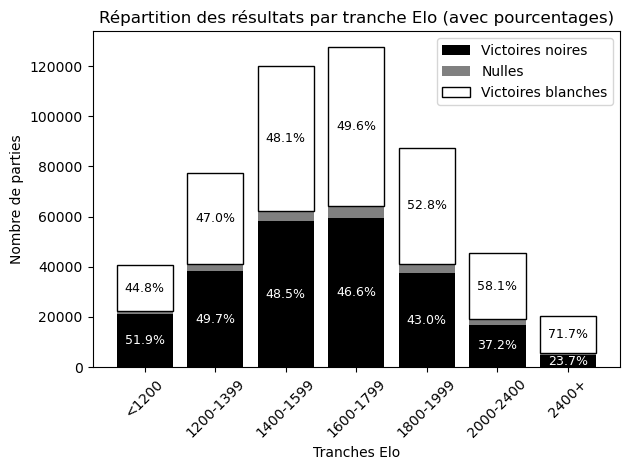

In [12]:
csv_file_path = "/home/onyxia/work/data/Database_finale.csv"  
df = pd.read_csv(csv_file_path)
valid_results = {"1-0", "0-1", "1/2-1/2"}
df_valid = df[df["Result"].isin(valid_results)]

bins = [0, 1200, 1400, 1600, 1800, 2000, 2400, 3000]
labels = ["<1200", "1200-1399", "1400-1599", "1600-1799", "1800-1999", "2000-2400", "2400+"]
df_valid["Tranche_Elo"] = pd.cut(df_valid["WhiteElo"], bins=bins, labels=labels, right=False)
grouped = df_valid.groupby("Tranche_Elo")["Result"].value_counts().unstack(fill_value=0)

black_wins = grouped.get("0-1", 0)
draws = grouped.get("1/2-1/2", 0)
white_wins = grouped.get("1-0", 0)
total_results = black_wins + draws + white_wins

factor = 10
black_wins["2400+"] *= factor
draws["2400+"] *= factor
white_wins["2400+"] *= factor
total_results = black_wins + draws + white_wins


x = labels  
plt.bar(x, black_wins, color="black", label="Victoires noires")
plt.bar(x, draws, bottom=black_wins, color="gray", label="Nulles")
plt.bar(x, white_wins, bottom=black_wins + draws, color="white", edgecolor="black", label="Victoires blanches")

for i, (bw, ww, total) in enumerate(zip(black_wins, white_wins, total_results)):
    if total > 0:
        plt.text(i, bw / 2, f"{bw / total * 100:.1f}%", color="white", ha="center", va="center", fontsize=9)
        plt.text(i, black_wins[i] + draws[i] + ww / 2, f"{ww / total * 100:.1f}%", color="black", ha="center", va="center", fontsize=9)


plt.title("Répartition des résultats par tranche Elo (avec pourcentages)")
plt.xlabel("Tranches Elo")
plt.ylabel("Nombre de parties")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Premièrement, on retrouve une distribution gaussienne des joueurs sur la plateforme (attention la colonne 2400+ a été agrandi par souci de visibilité). Ensuite, on remarque un effet inverse à bas niveau où les noirs semblent gagner plus souvent que les blancs. Globalement, plus le niveau est élevé plus les blancs semblent dominer (on pourrait dire que les joueurs savent quoi faire avec leur avantage). Cependant, il peut être utile de savoir qu'en réalité, les échecs sont un jeu très annulant et qu'au top niveau mondial, la proportion de nulle est plus élevé que celle des parties décisives même si effectivement, les noirs ne gagnent plus que très rarement. On ne peut pas retrouver ce phénomène ici puisqu'il s'agit de partie en ligne, majoritairement de niveau intermédiaire et jouée dans des cadences courtes (10min<).

J'ai avancé l'argument de "savoir quoi faire" pour expliquer le fait que l'avantage des blancs est plus visible à haut elo mais un autre paramètre important influençant la qualité des coups joués est la cadence. On peut donc s'intéresser au même graphique mais par cadence:

/tmp/ipykernel_1901/2637349613.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid["Tranche_Elo"] = pd.cut(df_valid["WhiteElo"], bins=bins, labels=labels, right=False)
/tmp/ipykernel_1901/2637349613.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_valid.groupby("Tranche_Elo")["Result"].value_counts().unstack(fill_value=0)
/tmp/ipykernel_1901/2637349613.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behav

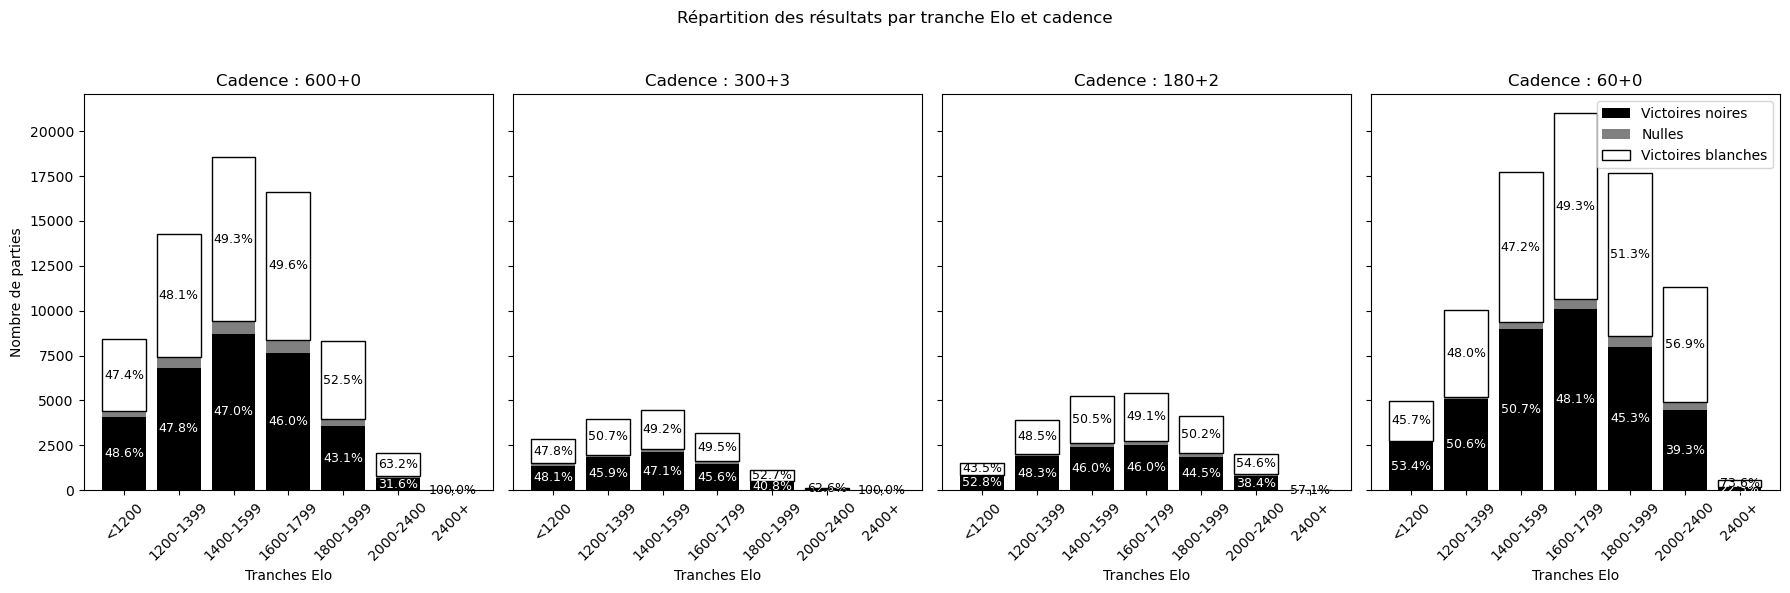

In [5]:
csv_file_path = "/home/onyxia/work/data/Database_finale.csv"
df = pd.read_csv(csv_file_path)
valid_results = {"1-0", "0-1", "1/2-1/2"}
time_controls = ["600+0", "300+3", "180+2", "60+0"]  # Cadences à analyser (sous la forme capital de départ en s + incrément en s)

bins = [0, 1200, 1400, 1600, 1800, 2000, 2400, 3000]
labels = ["<1200", "1200-1399", "1400-1599", "1600-1799", "1800-1999", "2000-2400", "2400+"]


fig, axes = plt.subplots(1, len(time_controls), figsize=(18, 6), sharey=True)

for ax, time_control in zip(axes, time_controls):
    df_valid = df[(df["Result"].isin(valid_results)) & (df["TimeControl"] == time_control)]
    df_valid["Tranche_Elo"] = pd.cut(df_valid["WhiteElo"], bins=bins, labels=labels, right=False)
    grouped = df_valid.groupby("Tranche_Elo")["Result"].value_counts().unstack(fill_value=0)

    black_wins = grouped.get("0-1", 0)
    draws = grouped.get("1/2-1/2", 0)
    white_wins = grouped.get("1-0", 0)
    total_results = black_wins + draws + white_wins

    x = labels
    ax.bar(x, black_wins, color="black", label="Victoires noires")
    ax.bar(x, draws, bottom=black_wins, color="gray", label="Nulles")
    ax.bar(x, white_wins, bottom=black_wins + draws, color="white", edgecolor="black", label="Victoires blanches")

    for i, (bw, ww, total) in enumerate(zip(black_wins, white_wins, total_results)):
        if total > 0:
            ax.text(i, bw / 2, f"{bw / total * 100:.1f}%", color="white", ha="center", va="center", fontsize=9)
            ax.text(i, black_wins[i] + draws[i] + ww / 2, f"{ww / total * 100:.1f}%", color="black", ha="center", va="center", fontsize=9)

    ax.set_title(f"Cadence : {time_control}")
    ax.set_xlabel("Tranches Elo")
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45)

fig.suptitle("Répartition des résultats par tranche Elo et cadence")
axes[0].set_ylabel("Nombre de parties")
axes[-1].legend(loc="upper right")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Ces graphiques représentent les résultats pour 4 des cadences les plus populaires sur lichess de droite à gauche et aussi de la plus longue à la plus courte: 10+0, 5+3, 3+2 et 1+0 (exprimé ici en min+s ce qui est plus standard). On remarque que en 1+0, l'absence de temps de réflexion a fait que les noirs gagnent plus que blancs jusqu'à 1600 elo (contre 1400 sans critère de cadence). De plus, la domination blanche à haut elo est aussi plus faible. De plus, dans la cadence la plus longue étudiée ici (10+0), les blancs semblent quasiment égaliser à bas elo tandis qu'à haut elo leur domination est tout aussi claire. Les cadences centrales se caractérisent par la présence d'un incrément qui théoriquement permet aux deux joueurs d'éviter de perdre au temps s'ils jouent assez vite. En 3+2, la cadence la plus courte des deux, les noirs dominent toujours dans la catégorie 1200< mais semblent égaliser dès la catégorie suivante malgré le faible temps. Ainsi, le temps de réflexion disponible semble favoriser les blancs à tout elo tandis que la présence d'un incrément atténue leur domination à haut elo. 

De manière générale, il semble donc que les facteurs améliorant la qualité des coups joués (temps de réflexion ou niveau des joueurs) tend à faire capitaliser les blancs sur leur avantage du trait (il joue en premier).

<u>Un peu de prédiction</u>

On va maintenant essayer de prédire le résultat d'une partie en connaissant les joueurs (leur elo) et la cadence de jeu à l'aide de notre base.
Pour cela, il faut par exemple prêter attention au fait que la cadence est de type string et il faut donc créer des variables supplémentaires (increment et temps total) qui elles seront de type int. On garde cependant les elos des 2 joueurs et l'on utilise pas la différence de elo du aux effets statistiques vu dans la partie précédente.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

csv_file_path = "/home/onyxia/work/data/Database_finale.csv"
df = pd.read_csv(csv_file_path)

df[['TotalTime', 'Increment']] = df['TimeControl'].str.split('+', expand=True)
df['TotalTime'] = pd.to_numeric(df['TotalTime'], errors='coerce')
df['Increment'] = pd.to_numeric(df['Increment'], errors='coerce')
df['TotalTime'] = df['TotalTime'].fillna(0)
df['Increment'] = df['Increment'].fillna(0)

X = df[['WhiteElo', 'BlackElo', 'TotalTime', 'Increment']]  
y = df['Result']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(class_weight= 'balanced', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.54384
              precision    recall  f1-score   support

           *       0.00      0.00      0.00        17
         0-1       0.54      0.54      0.54     46357
         1-0       0.56      0.58      0.57     49898
     1/2-1/2       0.03      0.01      0.02      3728

    accuracy                           0.54    100000
   macro avg       0.28      0.28      0.28    100000
weighted avg       0.53      0.54      0.54    100000



Le modèle n'est pas très précis, il a notamment énormément de mal à prédire les parties nulles qui ne sont pas très représentées dans les données.  Les prédictions de gain noir ou blanc ont quant à elle des performances relativement équivalentes.

On va maintenant essayer de prédire des résultats de parties via le code suivant:

In [35]:
def predict_game_result(white_elo, black_elo, total_time, increment):
    partie_data = pd.DataFrame({
        'WhiteElo': [white_elo],
        'BlackElo': [black_elo],
        'TotalTime': [total_time],
        'Increment': [increment]})
    proba = model.predict_proba(partie_data)
    print(f"Probabilité de 0-1 (Défaite blanc) : {proba[0][0]:.4f}")
    print(f"Probabilité de 1-0 (Victoire blanc) : {proba[0][1]:.4f}")
    print(f"Probabilité de 1/2-1/2 (Match nul) : {proba[0][2]:.4f}")
    prediction = model.predict(partie_data)
    print(f"Le résultat prédit pour cette partie est : {prediction[0]}")


white_elo = 1800
black_elo = 1845
total_time = 600  ##de retour en s
increment = 5      

predict_game_result(white_elo, black_elo, total_time, increment)

Probabilité de 0-1 (Défaite blanc) : 0.0000
Probabilité de 1-0 (Victoire blanc) : 0.2500
Probabilité de 1/2-1/2 (Match nul) : 0.5600
Le résultat prédit pour cette partie est : 1-0


Vous pouvez maintenant essayer de rentrer les valeurs qui vous intéressent et prédire des résultats de parties. Attention cependant, le modèle est très peu performant.

<u>Conclusion:</u>

Les statistiques faites sur les données sont très satisfaisantes, donnent des résultats attendus et logiques. Cependant, le modèle utilisé est très faible et ses prédictions sont parfois incohérentes. La présence de nulle en très faible représentation dans les parties en ligne semble compliquer les prédictions. L'ajout d'informations personnalisées sur les joueurs pourraient permettre d'améliorer les prédictions du modèle. 

<u>Pour aller plus loin:</u>

J'ai choisi un sujet lié à une de mes passions, je me suis donc plutôt amusé (notamment à effectuer les statistiques) dans ce projet. Cependant, je me suis limité à un modèle très théorique qui ne prend en compte que des informations "extérieures" à la partie. J'aurais aimé pouvoir créer un modèle personnalisé qui aurait pris en compte l'historique des deux joueurs (via l'API lichess qui permet de récupérer toutes les parties d'un joueur) mais aussi par exemple la position sur l'échiquier et le "style" des joueurs. J'aurais aussi aimé effectuer des statistiques sur l'ouverture mais je ne voulais pas surcharger la partie stat. 